# Argentina Stock Market - Metrics & Predictions

Install libraries required to get Finance data

In [58]:
!pip3 install statsmodels
!pip3 install pmdarima

    100% |████████████████████████████████| 1.5MB 147kB/s ta 0:00:011
    100% |████████████████████████████████| 296kB 2.5MB/s ta 0:00:01
    100% |████████████████████████████████| 7.0MB 207kB/s ta 0:00:011
    100% |████████████████████████████████| 2.1MB 638kB/s ta 0:00:011


Import all libraries used in the notebook

In [73]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA

In [4]:
df_stock_market = pd.read_csv('/dataset/argentina/tickers_argentina.csv', sep=';', decimal=',')  
df_stock_market = df_stock_market.reset_index()
del df_stock_market['index']
df_stock_market = df_stock_market.set_index(['Date'])

In [38]:
def get_portfolio(df, portfolio, allocation=None):
    
    df_ticker = None

    for ticker in portfolio_banking:

        if isinstance(df_ticker, pd.DataFrame) == False:
            df_ticker = df[df['Ticker']==ticker]      
        else:      
            df_ticker = pd.concat([df_ticker,df[df['Ticker']==ticker]])
            
        df_ticker = df_ticker.reset_index()
        df_ticker = df_ticker.set_index(['Date'])
        df_ticker.sort_index() 

    df_ticker['Adj_Close'] = df_ticker['Adj Close'] 
    del df_ticker['Adj Close']
    df_ticker.index = pd.to_datetime(df_ticker.index)
    df_ticker = df_ticker.drop(index=df_ticker.index.max())
    df_ticker.fillna(0)
    
    return df_ticker    

In [13]:
portfolio_banking = ['GGAL.BA', 'BMA.BA', 'SUPV.BA']
df_portfolio_banking = get_portfolio(df_stock_market, portfolio_banking)

**Optimizing the Portfolio**

**Markowitz Portfolio Optimization**

Is a theory on how risk-averse investors can construct portfolios to optimize or maximize expected return based on a given level of market risk, emphasizing that risk is an inherent part of higher reward. According to the theory, it's possible to construct an "efficient frontier" of optimal portfolios offering the maximum possible expected return for a given level of risk.

It makes the assumption that investors are risk-averse, meaning they prefer a less risky portfolio to a riskier one for a given level of return. This implies that an investor will take on more risk only if is expecting more reward.

In [14]:
def markowitz_portfolio_optimization(df, portfolio, number_of_possible_portfolio, trade_business_days = 252):

  all_weights = np.zeros((number_of_possible_portfolio, len(portfolio)))

  array_returns = np.zeros(number_of_possible_portfolio)
  array_volatility = np.zeros(number_of_possible_portfolio)
  array_sharpe = np.zeros(number_of_possible_portfolio)

  log_ret = np.log(df/df.shift(1))

  for index in range(number_of_possible_portfolio):

    #looking for the best weight in all portfolio based on relation Returns vs Volatility
    weights = np.array(np.random.random(len(portfolio)))
    weights = weights / np.sum(weights)

    all_weights[index,:] = weights
    array_returns[index] = np.sum(log_ret.mean()*weights*trade_business_days)
    array_volatility[index] = np.sqrt(np.dot(weights.T, np.dot(log_ret.cov() * trade_business_days, weights)))

    array_sharpe[index] = array_returns[index] / array_volatility[index]

  
  return [all_weights, array_returns, array_volatility, array_sharpe]


In [15]:
def simulate_portfolio(df, portfolio_banking, number_of_possible_portfolio):
  #call optimization function
  weights, returns, volatility, sharpe = markowitz_portfolio_optimization(df, portfolio_banking, number_of_possible_portfolio)

  #get best weights in the optimization process
  best_sharpe_weights = weights[sharpe.argmax(),:]

  plt.figure(figsize=(10,10))
  plt.scatter(volatility, returns, c=sharpe, cmap = 'viridis')
  plt.colorbar(label='Sharpe Ratio')
  plt.xlabel('Volatility')
  plt.ylabel('Return')
  plt.scatter(volatility[sharpe.argmax()], returns[sharpe.argmax()], c ='red', edgecolors='white', s=100)

Red point is the best relation between Returns vs Volatility

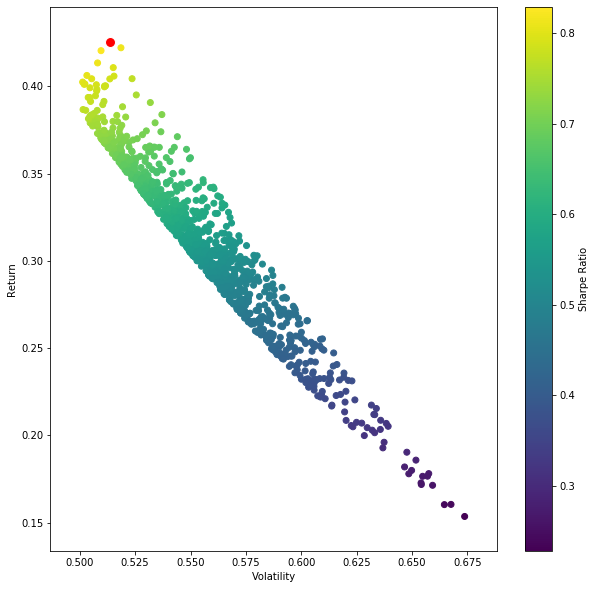

In [24]:
portfolio_banking = ['GGAL.BA', 'BMA.BA', 'SUPV.BA']
df_portfolio_banking = get_portfolio(df_stock_market, portfolio_banking)

df = df_portfolio_banking
df = df.drop(index=df.index.max())
df = df.reset_index() 
df = df.pivot(index='Date', columns='Ticker', values='Adj_Close')

simulate_portfolio(df, portfolio_banking, 1000)

**Compare Sharpe Ratio using different portfolios based on the metric**

The Sharpe ratio measures the performance of an investment compared to a risk-free asset, after adjusting for its risk. It is defined as the difference between the returns of the investment and the risk-free return, divided by the standard deviation of the investment.

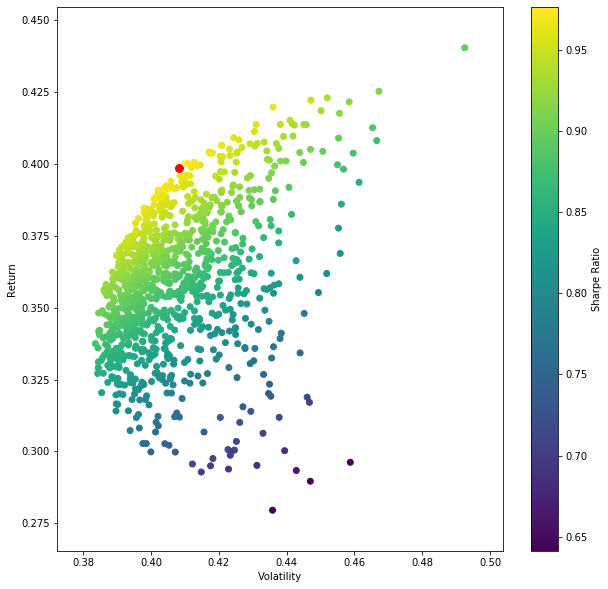

In [25]:
portfolio_banking = ['BHIP.BA', 'BPAT.BA', 'BRIO.BA', 'GGAL.BA']
df_portfolio_banking = get_portfolio(df_stock_market, portfolio_banking)

df = df_portfolio_banking
df = df.drop(index=df.index.max())
df = df.reset_index() 
df = df.pivot(index='Date', columns='Ticker', values='Adj_Close')

simulate_portfolio(df, portfolio_banking, 1000)

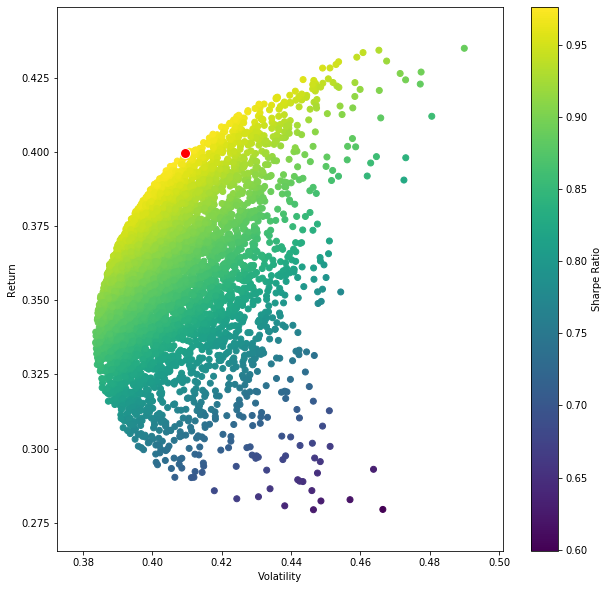

In [26]:
all_portfolio_banking = ['BRIO.BA', 'BPAT.BA']
df_portfolio_banking = get_portfolio(df_stock_market, portfolio_banking)

df = df_portfolio_banking
df = df.drop(index=df.index.max())
df = df.reset_index() 
df = df.pivot(index='Date', columns='Ticker', values='Adj_Close')

simulate_portfolio(df, portfolio_banking, 5000)

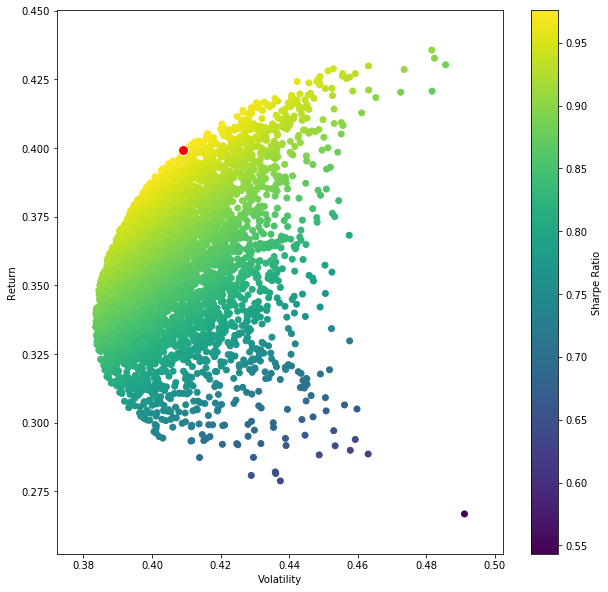

In [28]:
all_portfolio_banking = ['GGAL.BA', 'BMA.BA']
df_portfolio_banking = get_portfolio(df_stock_market, portfolio_banking)

df = df_portfolio_banking
df = df.drop(index=df.index.max())
df = df.reset_index() 
df = df.pivot(index='Date', columns='Ticker', values='Adj_Close')

simulate_portfolio(df, portfolio_banking, 5000)

**Predicting Ticker Price using History**

The history of the ticker price can get us a view what is the expected behaviour in the next days. This is just an approach because also the stock prices can be impacted by the government decision, natural disasters and so on.

In [75]:
def predict_price_by_history(df, ticker):
    
    df.fillna(0)
    
    result = seasonal_decompose(df, model='multiplicative', freq = 30)
    figure_season = plt.figure()  
    figure_season = result.plot()  
    figure_season.set_size_inches(10, 8)

    #eliminate trend component in serie
    df_log = np.log(df)
    train_data, test_data = df_log[3:int(len(df_log)*0.9)], df_log[int(len(df_log)*0.9):]
      
    plt.figure(figsize=(10,8))
    plt.grid(True)
    plt.xlabel('Date')
    plt.ylabel('Close Prices')
    plt.plot(df_log, 'blue', label='Train data')
    plt.plot(test_data, 'red', label='Test data')
    plt.legend()

    model = ARIMA(train_data, order=(3, 1, 2))  
    fitted = model.fit(disp=-1)  

    # Forecasting values with 95% conf
    fc, se, conf = fitted.forecast(27, alpha=0.05)

    fc_series = pd.Series(fc, index=test_data.index)
    lower_series = pd.Series(conf[:, 0], index=test_data.index)
    upper_series = pd.Series(conf[:, 1], index=test_data.index)

    plt.figure(figsize=(10,8))
    plt.plot(train_data, color = 'blue', label='Training')
    plt.plot(test_data, color = 'red', label='Actual Price')
    plt.plot(fc_series, color = 'orange',label='Predicted')
    plt.fill_between(lower_series.index, lower_series, upper_series, 
                      color='k', alpha=.10)
    plt.title(ticker + ' Price Prediction')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend(loc='upper left', fontsize=8)
    plt.show()

TICKER: GGAL.BA
0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: FutureWarning: the 'freq' keyword is deprecated, use 'period' instead
  """
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


<Figure size 432x288 with 0 Axes>

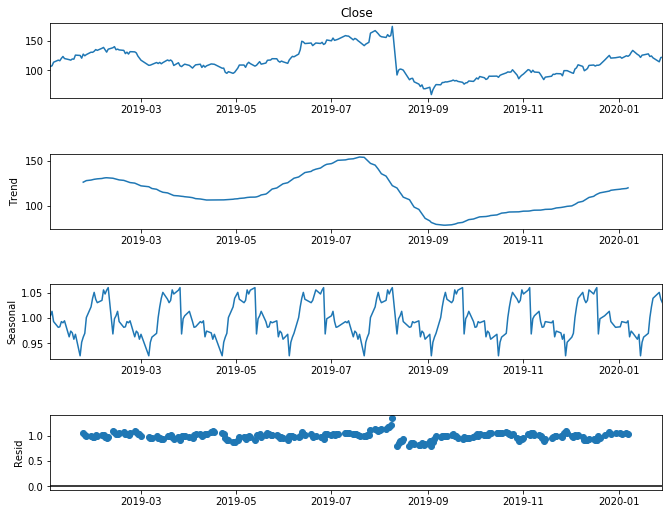

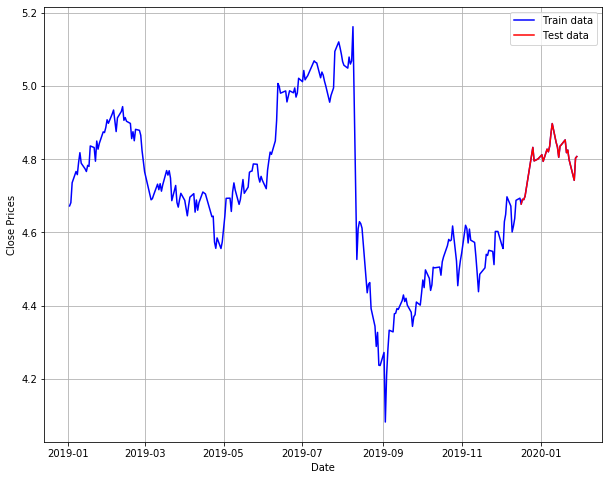

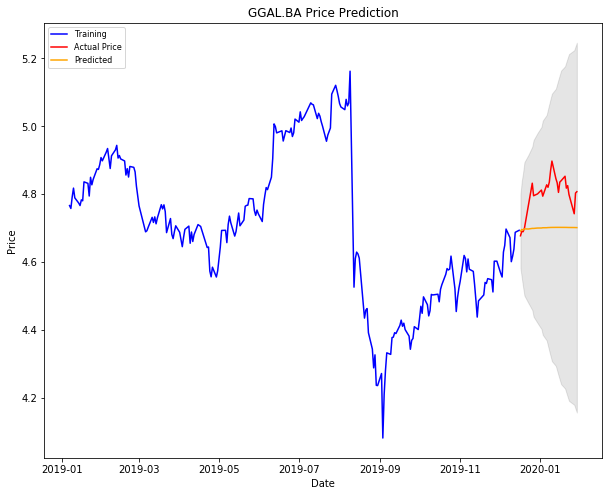

In [76]:
portfolio_banking = ['GGAL.BA']

for ticker in portfolio_banking:
    print("TICKER: " + ticker)
    df = get_portfolio(df_stock_market, portfolio_banking).fillna(0)  
    df = df.loc['2019-01-01':'2020-01-30']
    print(df['Close'].isnull().sum())
    predict_price_by_history(df['Close'], ticker)                  

TICKER: BRIO.BA
0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: FutureWarning: the 'freq' keyword is deprecated, use 'period' instead
  """
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


<Figure size 432x288 with 0 Axes>

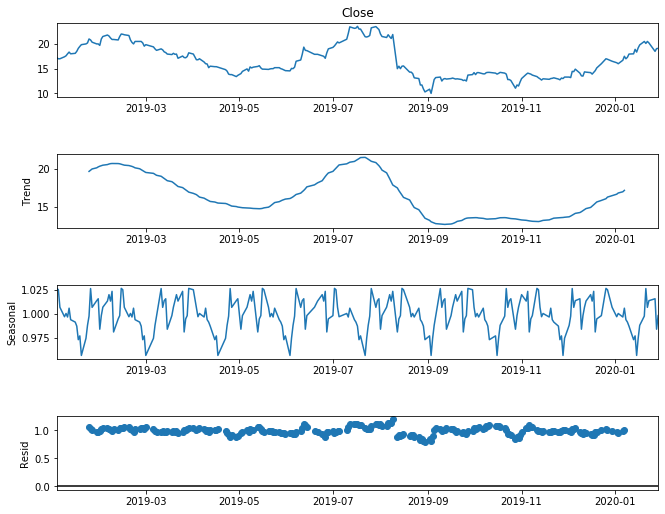

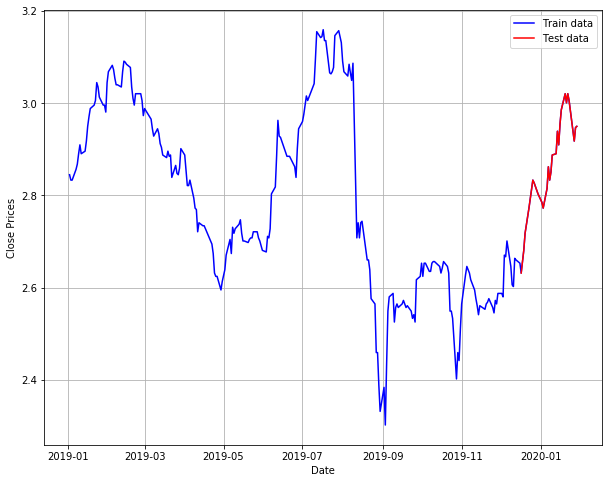

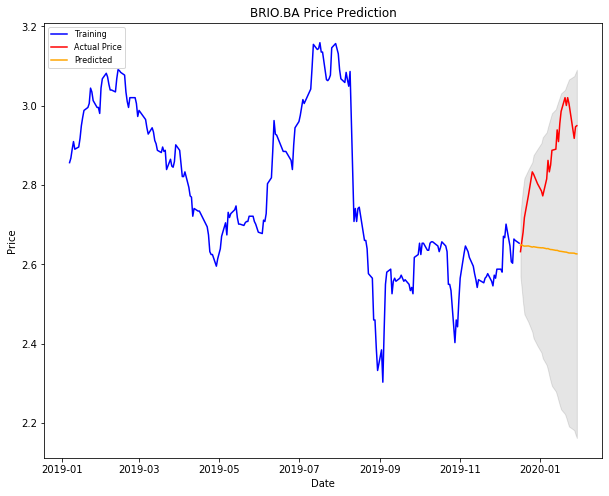

In [77]:
portfolio_banking = ['BRIO.BA']

for ticker in portfolio_banking:
    print("TICKER: " + ticker)
    df = get_portfolio(df_stock_market, portfolio_banking).fillna(0)  
    df = df.loc['2019-01-01':'2020-01-30']
    print(df['Close'].isnull().sum())
    predict_price_by_history(df['Close'], ticker)                  

TICKER: BPAT.BA
0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: FutureWarning: the 'freq' keyword is deprecated, use 'period' instead
  """
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


<Figure size 432x288 with 0 Axes>

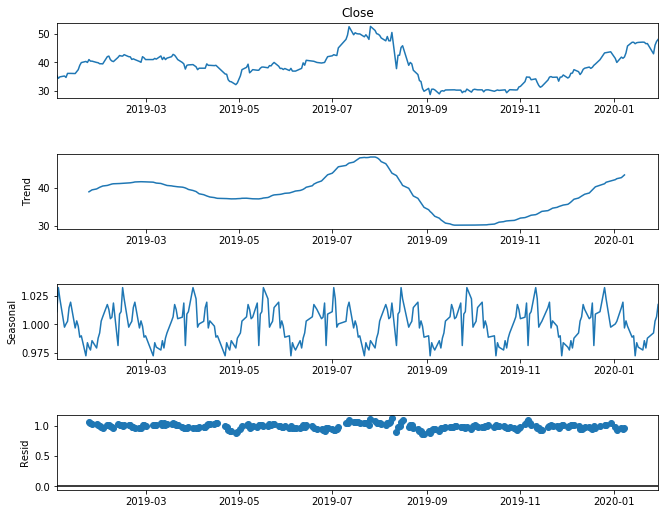

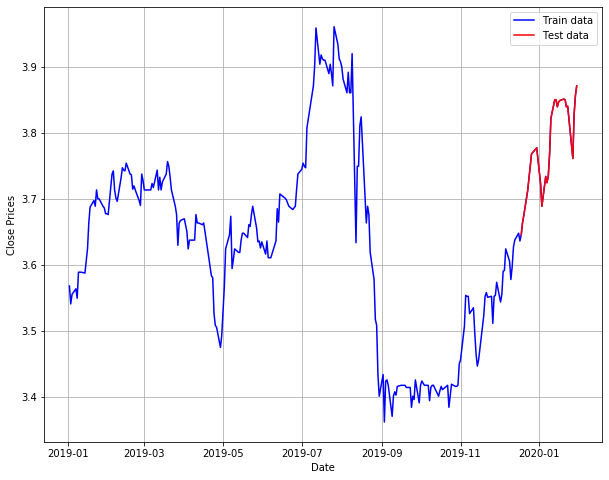

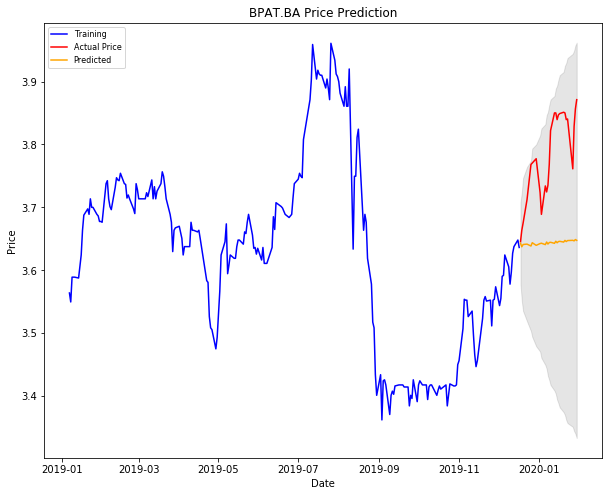

In [78]:
portfolio_banking = ['BPAT.BA']

for ticker in portfolio_banking:
    print("TICKER: " + ticker)
    df = get_portfolio(df_stock_market, portfolio_banking).fillna(0)  
    df = df.loc['2019-01-01':'2020-01-30']
    print(df['Close'].isnull().sum())
    predict_price_by_history(df['Close'], ticker)                  